In [15]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
import random
from tqdm import tqdm
import keras
from keras.models import Model
from keras.layers import Input, merge, Conv2D, MaxPooling2D, Flatten, UpSampling2D, Reshape, core, Dropout, BatchNormalization, concatenate, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from sklearn.metrics import jaccard_similarity_score, roc_curve, auc
import tensorflow as tf
from loss_functions_backend import jaccard_loss, iou_metric, recall, precision, f1
from np_metrics import np_jaccard_coef, np_recall, np_precision, np_f1
from keras.models import load_model
from keras.regularizers import l2 as l2_reg
import timeit
import predict_all_img
#from predict_all_img import split_image
%matplotlib inline

In [2]:
def pad_int_zeros(i, num_digits):
    res = str(i)
    for j in range(num_digits-len(res)):
        res = '0'+res
    return res

In [3]:
def split_image(img_dir, img_name, model, size = (192,240), shear = 0.25, img_type='aicd'):
    if img_type == 'tsunami':
        img_1_path = img_dir+'t0/'+img_name+'.jpg'
        img_2_path = img_dir+'t1/'+img_name+'.jpg'
        img_gt_path = img_dir+'ground_truth/'+img_name+'.bmp'
        
    elif img_type == 'aicd':
        img_1_path = img_dir+'Images_NoShadow/'+img_name+'_moving.png'
        img_2_path = img_dir+'Images_NoShadow/'+img_name+'_target.png'
        img_gt_path = img_dir+'GroundTruth/'+img_name+'_gtmask.png'

        
    img_1 = cv2.imread(img_1_path)
    img_2 = cv2.imread(img_2_path)
    img_gt = cv2.imread(img_gt_path,0)
    assert img_1 is not None
    assert img_2 is not None
    assert img_gt is not None

    if img_type=='tsunami':
        img_gt = cv2.bitwise_not(img_gt)
        
    img = np.empty((img_1.shape[0], img_1.shape[1], 6))
    img[:, :, :3] = img_1/255
    img[:, :, 3:] = img_2/255
    #img_gt = img_gt/255
                   
    h,w,_ = img.shape
    # Create reflective padding
    shear_int = (int(size[0]*shear),int(size[1]*shear))
    pad_h_1 = (size[0]-shear_int[0]-(h-size[0])%(size[0]-shear_int[0]))//2
    pad_h_2 = (size[0]-shear_int[0]-(h-size[0])%(size[0]-shear_int[0]))//2+(size[0]-shear_int[0]-(h-size[0])%(size[0]-shear_int[0]))%2
    pad_w_1 = (size[1]-shear_int[1]-(w-size[1])%(size[1]-shear_int[1]))//2
    pad_w_2 = (size[1]-shear_int[1]-(w-size[1])%(size[1]-shear_int[1]))//2+(size[1]-shear_int[1]-(w-size[1])%(size[1]-shear_int[1]))%2
    #print(pad_h_1,pad_h_2,pad_w_1,pad_w_2)
    img = np.pad(img,((pad_h_1,pad_h_2),(pad_w_1,pad_w_2),(0,0)), 'reflect')
    
    # Split image into patches
    h,w,_ = img.shape
    img_arr = []
    n_rows = (h-size[0])//(size[0]-shear_int[0])+1
    n_cols = (w-size[1])//(size[1]-shear_int[1])+1
    for i in range(n_rows):
        for j in range(n_cols):
            coord_h = i*(size[0]-shear_int[0])
            coord_w = j*(size[1]-shear_int[1])
            img_crop = img[coord_h:coord_h+size[0], coord_w:coord_w+size[1],:]
            img_arr.append(img_crop)
 
    # Create predictions for patches
    mask_arr = []
    for img_crop in img_arr:
        img_to_pred = np.array([img_crop])
        mask_pred = model.predict(img_to_pred)[0]
        mask_arr.append(mask_pred)
    
    # Merge masks in one
    index = 0
    channels = 1
    final_seg = np.zeros((h,w))
    for i in range (n_rows):
        for j in range (n_cols):
            #print(i,j)
            coord_h = i*(size[0]-shear_int[0])
            coord_w = j*(size[1]-shear_int[1])
            
            shift_h = shear_int[0]//2
            shift_w = shear_int[1]//2
            
            mask_to_append = mask_arr[index]
            mask_to_append[0:shift_h,:]=0
            mask_to_append[size[0]-shift_h:,:]=0
            mask_to_append[:,0:shift_w]=0
            mask_to_append[:,size[1]-shift_w:]=0
                
            final_seg[coord_h:coord_h+size[0], coord_w:coord_w+size[1]]+=mask_to_append
            index+=1
    #print(final_seg.shape)
    final_seg = final_seg[pad_h_1:h-pad_h_2, pad_w_1:w-pad_w_2]
    return final_seg, img_gt

In [4]:
DATASET_DIR='../data/train_test_val_fixed_test/'
smooth = 1e-12

In [5]:
class BatchGeneratorStatic(object):
    
    def __init__(self, batch_size = 32, dim_x = 240, dim_y = 192, dim_z = 6, shuffle = True):
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.batch_size = batch_size
        self.shuffle = shuffle

    def generate(self, dir_name, file_names):
        # Infinite loop
        while 1:
        # Generate order of exploration of dataset
            indexes = self.__get_exploration_order(file_names)

            # Generate batches
            imax = int(len(indexes)/self.batch_size)
            for i in range(imax):
                # Find list of IDs
                list_files_temp = [file_names[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]
                # Generate data
                X_out, y_out = self.data_generation(dir_name, list_files_temp)

                yield X_out, y_out

    def __get_exploration_order(self, X):
        
        # Find exploration order
        indexes = np.arange(len(X))
        if self.shuffle == True:
            np.random.shuffle(indexes)

        return indexes

    def data_generation(self, dir_name, list_files_temp):
        # X : (n_samples, v_size, v_size, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.dim_y, self.dim_x, self.dim_z))
        y = np.empty((self.batch_size, self.dim_y, self.dim_x))

        # Generate data
        for i in range(len(list_files_temp)):
            # Store volume
            img_1 = cv2.imread(dir_name+'1/'+list_files_temp[i])
            img_2 = cv2.imread(dir_name+'2/'+list_files_temp[i])
            img_gt = cv2.imread(dir_name+'gt/'+list_files_temp[i],0)
            
            #print(img.shape)
            X[i, :, :, :3] = img_1/255
            X[i, :, :, 3:] = img_2/255
            
            y[i, :, :]=img_gt/255

            
            #y = y/255
            #y=y.flatten()
        return X, y
    def debug(self, X, y):
        indexes = self.__get_exploration_order(X)
        imax = int(len(indexes)/self.batch_size)
        for i in range(1):
            # Find list of IDs
            list_files_temp = [file_names[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]
            # Generate data
            X_out, y_out = self.data_generation(dir_name, list_files_temp)
            return  X_out, y_out

In [6]:
# dir_name = DATASET_DIR+'test/'
# file_names = os.listdir(dir_name+'1/')

# X,y = BatchGeneratorStatic().debug(dir_name, file_names)

In [7]:
# LOADING DATASETS
train_dir = DATASET_DIR+'train/'
train_data = os.listdir(DATASET_DIR+'train/1')
val_dir = DATASET_DIR+'val/'
val_data = os.listdir(DATASET_DIR+'val/1')

In [8]:
inputs = Input((192,240,6))
bn0 = BatchNormalization()(inputs)

conv1 = Conv2D(64, (7, 7), padding='same', kernel_regularizer=l2_reg(0.001))(bn0)
bn1 = BatchNormalization()(conv1)
ac1 = Activation('relu')(bn1)
mp1 = MaxPooling2D(pool_size=(2, 2), strides=2)(ac1)

conv2 = Conv2D(128, (7, 7), padding='same', kernel_regularizer=l2_reg(0.001))(mp1)
bn2 = BatchNormalization()(conv2)
ac2 = Activation('relu')(bn2)
mp2 = MaxPooling2D(pool_size=(2, 2), strides=2)(ac2)

conv3 = Conv2D(256, (7, 7), padding='same', kernel_regularizer=l2_reg(0.001))(mp2)
bn3 = BatchNormalization()(conv3)
ac3 = Activation('relu')(bn3)
mp3 = MaxPooling2D(pool_size=(2, 2), strides=2)(ac3)

conv4 = Conv2D(512, (7, 7), padding='same', kernel_regularizer=l2_reg(0.001))(mp3)
bn4 = BatchNormalization()(conv4)
ac4 = Activation('relu')(bn4)
mp4 = MaxPooling2D(pool_size=(2, 2), strides=2)(ac4)

up5 = UpSampling2D((2, 2))(mp4)
conv5 = Conv2D(512, (7, 7), padding='same', kernel_regularizer=l2_reg(0.001))(up5)
bn5 = BatchNormalization()(conv5)
ac5 = Activation('relu')(bn5)

up6 = UpSampling2D((2, 2))(ac5)
conv6 = Conv2D(256, (7, 7), padding='same', kernel_regularizer=l2_reg(0.001))(up6)
bn6 = BatchNormalization()(conv6)
ac6 = Activation('relu')(bn6)

up7 = UpSampling2D((2, 2))(ac6)
conv7 = Conv2D(128, (7, 7), padding='same', kernel_regularizer=l2_reg(0.001))(up7)
bn7 = BatchNormalization()(conv7)
ac7 = Activation('relu')(bn7)

up8 = UpSampling2D((2, 2))(ac7)
conv8 = Conv2D(64, (7, 7), padding='same', kernel_regularizer=l2_reg(0.001))(up8)
bn8 = BatchNormalization()(conv8)
ac8 = Activation('relu')(bn8)

conv9 = Conv2D(1, (7, 7), activation='sigmoid', padding='same', kernel_regularizer=l2_reg(0.001))(ac8)

rh1 = Reshape((192, 240))(conv9)
#rh1 = Flatten()(conv9)

model = Model(inputs=inputs, outputs=rh1)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 192, 240, 6)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 192, 240, 6)       24        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 240, 64)      18880     
_________________________________________________________________
batch_normalization_2 (Batch (None, 192, 240, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 192, 240, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 96, 120, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 120, 128)      401536    
__________

In [18]:
inputs = Input((192,240,6))
bn1 = BatchNormalization()(inputs)
conv1 = Conv2D(32, (3, 3), padding='same')(bn1)
bn1 = BatchNormalization()(conv1)
act1 = Activation('relu')(bn1)
conv1 = Conv2D(32, (3, 3), padding='same')(act1)
bn1 = BatchNormalization()(conv1)
act1 = Activation('relu')(bn1)
pool1 = MaxPooling2D(pool_size=(2, 2))(act1)

conv2 = Conv2D(64, (3, 3), padding='same')(pool1)
bn2 = BatchNormalization()(conv2)
act2 = Activation('relu')(bn2)
conv2 = Conv2D(64, (3, 3), padding='same')(act2)
bn2 = BatchNormalization()(conv2)
act2 = Activation('relu')(bn2)
pool2 = MaxPooling2D(pool_size=(2, 2))(act2)

conv3 = Conv2D(128, (3, 3), padding='same')(pool2)
bn3 = BatchNormalization()(conv3)
act3 = Activation('relu')(bn3)
conv3 = Conv2D(128, (3, 3), padding='same')(act3)
bn3 = BatchNormalization()(conv3)
act3 = Activation('relu')(bn3)
pool3 = MaxPooling2D(pool_size=(2, 2))(act3)

conv4 = Conv2D(256, (3, 3), padding='same')(pool3)
bn4 = BatchNormalization()(conv4)
act4 = Activation('relu')(bn4)
conv4 = Conv2D(256, (3, 3), padding='same')(act4)
bn4 = BatchNormalization()(conv4)
act4 = Activation('relu')(bn4)
pool4 = MaxPooling2D(pool_size=(2, 2))(act4)

conv5 = Conv2D(512, (3, 3), padding='same')(pool4)
bn5 = BatchNormalization()(conv5)
act5 = Activation('relu')(bn5)
conv5 = Conv2D(512, (3, 3), padding='same')(act5)
bn5 = BatchNormalization()(conv5)
act5 = Activation('relu')(bn5)

up6 = concatenate([UpSampling2D(size=(2, 2))(act5), act4], axis=3)
conv6 = Conv2D(256, (3, 3), padding='same')(up6)
bn6 = BatchNormalization()(conv6)
act6 = Activation('relu')(bn6)
conv6 = Conv2D(256, (3, 3), padding='same')(act6)
bn6 = BatchNormalization()(conv6)
act6 = Activation('relu')(bn6)

up7 = concatenate([UpSampling2D(size=(2, 2))(act6), act3], axis =3 )
conv7 = Conv2D(128, (3, 3), padding='same')(up7)
bn7 = BatchNormalization()(conv7)
act7 = Activation('relu')(bn7)
conv7 = Conv2D(128, (3, 3), padding='same')(act7)
bn7 = BatchNormalization()(conv7)
act7 = Activation('relu')(bn7)

up8 = concatenate([UpSampling2D(size=(2, 2))(act7), act2], axis=3)
conv8 = Conv2D(64, (3, 3), padding='same')(up8)
bn8 = BatchNormalization()(conv8)
act8 = Activation('relu')(bn8)
conv8 = Conv2D(64, (3, 3), padding='same')(act8)
bn8 = BatchNormalization()(conv8)
act8 = Activation('relu')(bn8)

up9 = concatenate([UpSampling2D(size=(2, 2))(act8), act1], axis=3)
conv9 = Conv2D(32, (3, 3), padding='same')(up9)
bn9 = BatchNormalization()(conv9)
act9 = Activation('relu')(bn9)
conv9 = Conv2D(32, (3, 3), padding='same')(act9)
bn9 = BatchNormalization()(conv9)
act9 = Activation('relu')(bn9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(act9)

rh1 = Reshape((192, 240))(conv10)

model = Model(inputs=inputs, outputs=rh1, name = 'Unet')
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 192, 240, 6)   0                                            
____________________________________________________________________________________________________
batch_normalization_28 (BatchNor (None, 192, 240, 6)   24          input_4[0][0]                    
____________________________________________________________________________________________________
conv2d_28 (Conv2D)               (None, 192, 240, 32)  1760        batch_normalization_28[0][0]     
____________________________________________________________________________________________________
batch_normalization_29 (BatchNor (None, 192, 240, 32)  128         conv2d_28[0][0]                  
___________________________________________________________________________________________

In [ ]:
EPOCHS = 15
epoch_num = EPOCHS
prev_val_iou=0
learning_rate = 0.01
prev_weghts_caption = ''
prev_epoch = 0

while epoch_num>0:
    print('Epoch {}'.format(str(EPOCHS-epoch_num)))
    epoch_num -= 1
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss=jaccard_loss, optimizer=optimizer, metrics=[jaccard_coef_int, iou_metric, precision, recall, f1])
    batch_size = 5
    training_generator = BatchGeneratorStatic(batch_size = batch_size).generate(train_dir, train_data)
    validation_generator = BatchGeneratorStatic(batch_size = batch_size).generate(val_dir, val_data)

    fit_results = model.fit_generator(generator = training_generator,
                            steps_per_epoch = 400,
                            validation_data = validation_generator,
                            validation_steps = int(len(val_data)//batch_size), verbose = True,epochs= 1)
    metrics_dict = fit_results.history
    if metrics_dict['val_iou_metric'][0] > prev_val_iou:
        prev_val_iou = metrics_dict['val_iou_metric'][0]
        prev_weghts_caption = 'version2_shadows/weights/aicd_epoch{}-{}_weights_train{}iou_val{}iou.4f'.format(str(EPOCHS - epoch_num), str(prev_epoch), metrics_dict['iou_metric'][0],
                                                                                   metrics_dict['val_iou_metric'][0])
        model.save_weights(prev_weghts_caption)
        prev_epoch = EPOCHS - epoch_num
    else:
        learning_rate /= 2
        model.load_weights(prev_weghts_caption)

Epoch 0
Epoch 1/1
400/400 [==============================] - 209s 523ms/step - loss: 2.5925 - jaccard_coef_int: 0.1128 - iou_metric: 0.1128 - precision: 0.2240 - recall: 0.4894 - f1: nan - val_loss: 2.4539 - val_jaccard_coef_int: 0.2397 - val_iou_metric: 0.2397 - val_precision: 0.3311 - val_recall: 0.6579 - val_f1: nan
Epoch 1
Epoch 1/1
400/400 [==============================] - 205s 513ms/step - loss: 2.2737 - jaccard_coef_int: 0.4081 - iou_metric: 0.4081 - precision: 0.5939 - recall: 0.6017 - f1: nan - val_loss: 2.2029 - val_jaccard_coef_int: 0.4666 - val_iou_metric: 0.4666 - val_precision: 0.6043 - val_recall: 0.6973 - val_f1: nan
Epoch 2
Epoch 1/1
400/400 [==============================] - 204s 510ms/step - loss: 2.2193 - jaccard_coef_int: 0.4381 - iou_metric: 0.4381 - precision: 0.6269 - recall: 0.6182 - f1: nan - val_loss: 2.4029 - val_jaccard_coef_int: 0.2425 - val_iou_metric: 0.2425 - val_precision: 0.3411 - val_recall: 0.4869 - val_f1: nan
Epoch 3
Epoch 1/1
 23/400 [>.........

In [ ]:
model.save("version2_shadows/models/model.h5")

In [43]:
fit_results.history

{'f1': [nan],
 'iou_metric': [0.046460526836390202],
 'jaccard_coef_int': [0.04646043696266134],
 'loss': [2.6593033772706987],
 'precision': [0.09942082928730088],
 'recall': [0.63072432607848894],
 'val_f1': [nan],
 'val_iou_metric': [0.11832720245674615],
 'val_jaccard_coef_int': [0.11832706198015092],
 'val_loss': [2.5753893789492155],
 'val_precision': [0.19028585957697175],
 'val_recall': [0.63354526431250724]}

In [34]:
model.save_weights('weights/aicd-7-6weights_1ep_00005lr_tr06916iou_val07026iou.4f')

In [9]:
model.load_weights('version_2/weights/aicd_epoch8_weights_train[0.68601577908602218]iou_val[0.69648463564989926]iou.4f')

In [10]:
# LOADING DATASETS
train_dir = DATASET_DIR+'train/'
train_data = os.listdir(DATASET_DIR+'train/1')
val_dir = DATASET_DIR+'val/'
val_data = os.listdir(DATASET_DIR+'val/1')
test_dir = DATASET_DIR+'test/'
test_data = os.listdir(DATASET_DIR+'test/1')

In [13]:
mode='test'
all_img=False

if mode=='val':
    data_dir=val_dir
    data=val_data
elif mode=='train':
    data_dir=train_dir
    data=train_data
elif mode=='test':
    data_dir=test_dir
    data=test_data
    
len_data=len(data)
if not all_img:
    len_data = 100

X = np.empty((len_data, 192, 240, 6))
y = np.empty((len_data, 192, 240))

# Generate data
for i in range(len_data):
    # Store volume
    img_1 = cv2.imread(data_dir+'1/'+data[i])
    img_2 = cv2.imread(data_dir+'2/'+data[i])
    img_gt = cv2.imread(data_dir+'gt/'+data[i],0)

    #print(img.shape)
    X[i, :, :, :3] = img_1/255
    X[i, :, :, 3:] = img_2/255

    y[i, :, :]=img_gt/255


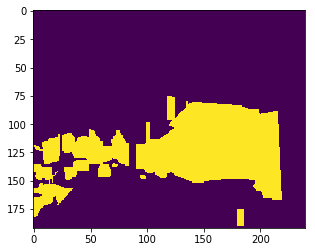

In [26]:
plt.imshow(y[0,:,:])

In [18]:
%timeit y_pred = model.predict(X)

6.26 s ± 294 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
batch_size = 5

y_pred = np.empty((len(data), 192, 240))

for i in tqdm(range(0, len(data), batch_size)):
    y_pred[i:i+batch_size,:,:] = model.predict(X[i:i+batch_size,:,:])

100%|██████████| 20/20 [00:04<00:00,  4.01it/s]


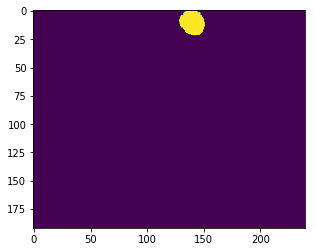

In [23]:
plt.imshow(y_pred[0,:,:])

In [11]:
#predict for test, for whole images
dataset_dir = '../data/AICDDataset/'
imgs_pred = []
imgs_gt = []
img_names = []
for scene_id in tqdm(range(95,100)):
    for view in tqdm(range(5)):
        img_path = 'Scene{}_View{}'.format(pad_int_zeros(scene_id, 4), pad_int_zeros(view, 2))
        img, img_gt = split_image(dataset_dir, img_path, model)
        imgs_pred.append(img)
        imgs_gt.append(img_gt)
        img_names.append(img_path)

100%|██████████| 5/5 [00:23<00:00,  4.63s/it]


In [85]:
# write predicted to images, include gt
RESULT_DIR='result/'
assert len(imgs_pred) == len(imgs_gt)
assert len(imgs_pred) == len(img_names)
for i in range(len(imgs_pred)):
    plt.imsave(RESULT_DIR+img_names[i]+'_gt.png', imgs_gt[i])
    plt.imsave(RESULT_DIR+img_names[i]+'_pred.png', imgs_pred[i])

In [89]:
imgs_gt[0].shape[0]

600

In [14]:
assert len(imgs_pred) == len(imgs_gt)
y_gt = np.empty((len(imgs_gt), imgs_gt[0].shape[0], imgs_gt[0].shape[1]))
y_pred = np.empty((len(imgs_pred), imgs_pred[0].shape[0], imgs_pred[0].shape[1]))
for i in range(len(imgs_pred)):
    y_gt[i, :, :] = imgs_gt[i]/255
    y_pred[i, :, :] = imgs_pred[i]
    print(img_names[i])
    print(np_jaccard_coef(y_pred[i, :, :] , y_gt[i, :, :]))
    print(np_precision(y_pred[i, :, :] ,y_gt[i, :, :]))
    print(np_recall(y_pred[i, :, :] ,y_gt[i, :, :]))
    print(np_f1(y_pred[i, :, :] ,y_gt[i, :, :]))
    print('------------------------------------')

Scene0095_View00
0.225168161266
0.228323699422
1.0
0.371764705882
------------------------------------
Scene0095_View01
0.0246326566323
0.0
nan
nan
------------------------------------
Scene0095_View02
0.380380406928
0.401617250674
0.90303030303
0.555970149254
------------------------------------
Scene0095_View03
0.446841327735
0.471052631579
0.937172774869
0.626970227671
------------------------------------
Scene0095_View04
0.0675264721239
0.0204603580563
1.0
0.0401002506266
------------------------------------
Scene0096_View00
0.609303401623
0.627218934911
0.96803652968
0.761220825853
------------------------------------
Scene0096_View01
0.648615529486
0.684813753582
0.944664031621


/opt/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


0.794019933555
------------------------------------
Scene0096_View02
0.565917641699
0.587078651685
0.972093023256
0.732049036778
------------------------------------
Scene0096_View03
0.659195514143
0.686111111111
0.953667953668
0.798061389338
------------------------------------
Scene0096_View04
0.643046981061
0.673184357542
0.945098039216
0.786296900489
------------------------------------
Scene0097_View00
0.704129087282
0.768402154399
0.899159663866
0.828654404647
------------------------------------
Scene0097_View01
0.691455310909
0.732600732601
0.92807424594
0.818833162743
------------------------------------
Scene0097_View02
0.67459022521
0.717712177122
0.921800947867
0.807053941909
------------------------------------
Scene0097_View03
0.650471521988
0.704460966543
0.89598108747
0.788761706556
------------------------------------
Scene0097_View04
0.647957289116
0.715094339623
0.875288683603
0.78712357217
------------------------------------
Scene0098_View00
0.676340727814
0.787671

In [22]:
img_=img.reshape(224, 1024, 1)
img_gt_=img_gt.reshape(224, 1024, 1)

In [44]:
print(np_jaccard_coef(y_pred , y))
print(np_precision(y_pred ,y))
print(np_recall(y_pred ,y))
print(np_f1(y_pred ,y))

0.700650388995
0.853662740592
0.798173515982
0.824986118823


In [95]:
np.max(y_gt[0,:,:])

255.0

In [59]:
fpr, tpr, thresholds = roc_curve(y.reshape(-1), y_pred.reshape(-1))

In [60]:
auc(fpr, tpr)

0.96270553848825235

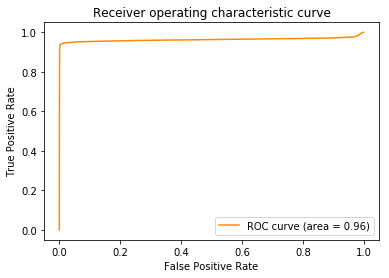

In [62]:
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [86]:
model.save("version_2/models/model.h5")

In [15]:
model = load_model("version_2/models/model.h5")

ValueError: Unknown loss function:jaccard_loss